In [1]:
# Importam bibliotecile de baza pentru analiza si ML
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Verificam ce fisiere exista in /content
print("Fisiere in /content:")
print(os.listdir("/content"))


Fisiere in /content:
['.config', 'models', 'products.csv', 'sample_data']


In [2]:
# Alegem automat primul fisier CSV gasit in /content
csv_files = [f for f in os.listdir("/content") if f.lower().endswith(".csv")]
print("CSV gasite:", csv_files)

CSV_PATH = "/content/" + csv_files[0]
print("Folosim CSV:", CSV_PATH)

# Incarcam dataset-ul
df = pd.read_csv(CSV_PATH)

# Curatam numele coloanelor (strip) ca sa evitam spatii invizibile
df.columns = [c.strip() for c in df.columns]

# Verificare rapida
df.shape, df.head(3)


CSV gasite: ['products.csv']
Folosim CSV: /content/products.csv


((35311, 8),
    product ID                                      Product Title  Merchant ID  \
 0           1                    apple iphone 8 plus 64gb silver            1   
 1           2                apple iphone 8 plus 64 gb spacegrau            2   
 2           3  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...            3   
 
   Category Label _Product Code  Number_of_Views  Merchant Rating Listing Date  
 0  Mobile Phones    QA-2276-XC            860.0              2.5    5/10/2024  
 1  Mobile Phones    KA-2501-QO           3772.0              4.8   12/31/2024  
 2  Mobile Phones    FP-8086-IE           3092.0              3.9   11/10/2024  )

In [3]:
# Facem curatarea minima necesara pentru modelare, eda_cleaning_baseline
LABEL_FIX = {
    "fridge": "Fridges",
    "CPU": "CPUs",
    "Mobile Phone": "Mobile Phones",
}

# Curatam titlul
df["Product Title"] = (
    df["Product Title"]
      .astype("string")
      .fillna("")
      .str.strip()
      .str.lower()
)

# Eliminam titlurile goale
df = df[df["Product Title"].str.len() > 0].copy()

# Curatam label-ul
df["Category Label"] = df["Category Label"].astype("string").str.strip()
df["Category Label"] = df["Category Label"].replace(LABEL_FIX)

# Eliminam randurile fara label
df = df[df["Category Label"].notna()].copy()

# Verificam dimensiunea dupa curatare
df.shape


(35096, 8)

In [4]:
# X = textul titlului
# y = categoria produsului
X = df["Product Title"]
y = df["Category Label"]

# Split stratified (pastram distributia claselor)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test), y.nunique()


(28076, 7020, 10)

In [5]:
# Model 1: TF-IDF + Logistic Regression
model_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

# Antrenam
model_lr.fit(X_train, y_train)

# Evaluam
pred_lr = model_lr.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)

print("TF-IDF + Logistic Regression - Accuracy:", acc_lr)
print("\nClassification report:\n")
print(classification_report(y_test, pred_lr))


TF-IDF + Logistic Regression - Accuracy: 0.9571225071225071

Classification report:

                  precision    recall  f1-score   support

            CPUs       1.00      0.99      1.00       766
 Digital Cameras       1.00      0.99      1.00       538
     Dishwashers       0.94      0.97      0.95       681
        Freezers       0.88      0.95      0.92       440
 Fridge Freezers       0.97      0.91      0.94      1094
         Fridges       0.88      0.91      0.89       712
      Microwaves       0.98      0.97      0.98       466
   Mobile Phones       0.95      0.99      0.97       812
             TVs       0.98      0.98      0.98       708
Washing Machines       0.97      0.92      0.95       803

        accuracy                           0.96      7020
       macro avg       0.96      0.96      0.96      7020
    weighted avg       0.96      0.96      0.96      7020



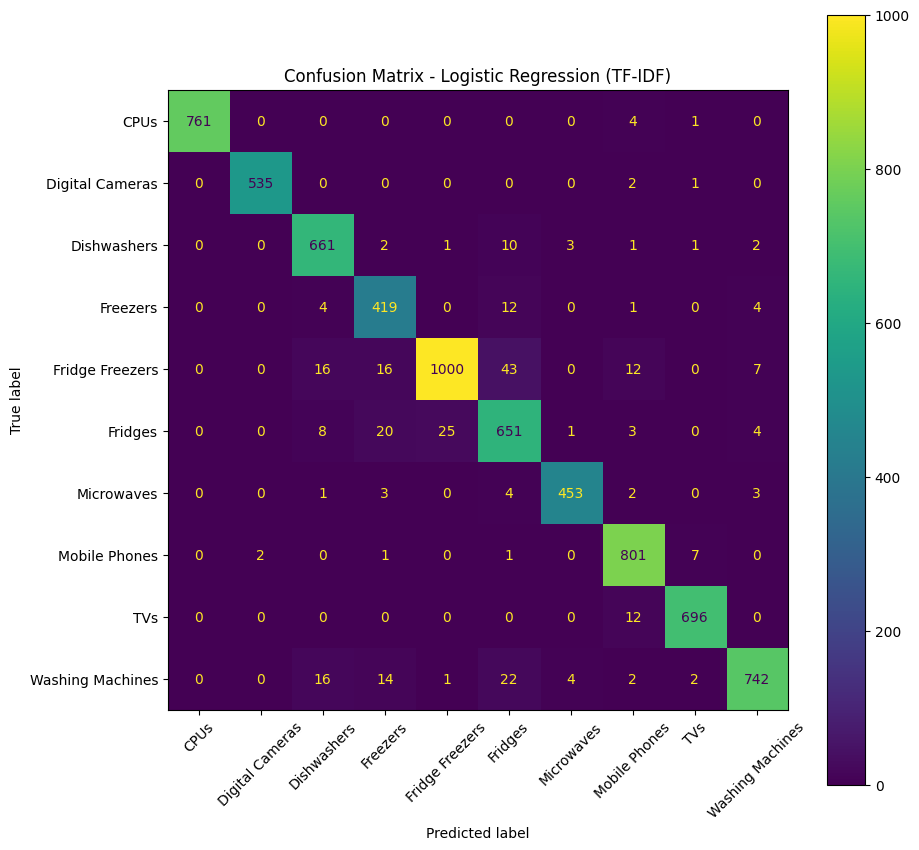

In [6]:
# Confusion matrix ne arata unde se incurca modelul intre categorii
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(
    model_lr, X_test, y_test,
    xticks_rotation=45,
    ax=ax
)
plt.title("Confusion Matrix - Logistic Regression (TF-IDF)")
plt.show()


In [7]:
# Model 2: TF-IDF + LinearSVC (de obicei foarte bun pe text)
model_svc = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])

# Antrenam
model_svc.fit(X_train, y_train)

# Evaluam
pred_svc = model_svc.predict(X_test)
acc_svc = accuracy_score(y_test, pred_svc)

print("TF-IDF + LinearSVC - Accuracy:", acc_svc)
print("\nClassification report:\n")
print(classification_report(y_test, pred_svc))


TF-IDF + LinearSVC - Accuracy: 0.9655270655270656

Classification report:

                  precision    recall  f1-score   support

            CPUs       1.00      1.00      1.00       766
 Digital Cameras       1.00      0.99      1.00       538
     Dishwashers       0.94      0.97      0.95       681
        Freezers       0.90      0.96      0.93       440
 Fridge Freezers       0.96      0.95      0.96      1094
         Fridges       0.91      0.92      0.92       712
      Microwaves       0.98      0.97      0.98       466
   Mobile Phones       0.98      0.99      0.98       812
             TVs       0.98      0.99      0.98       708
Washing Machines       0.99      0.93      0.96       803

        accuracy                           0.97      7020
       macro avg       0.96      0.97      0.97      7020
    weighted avg       0.97      0.97      0.97      7020



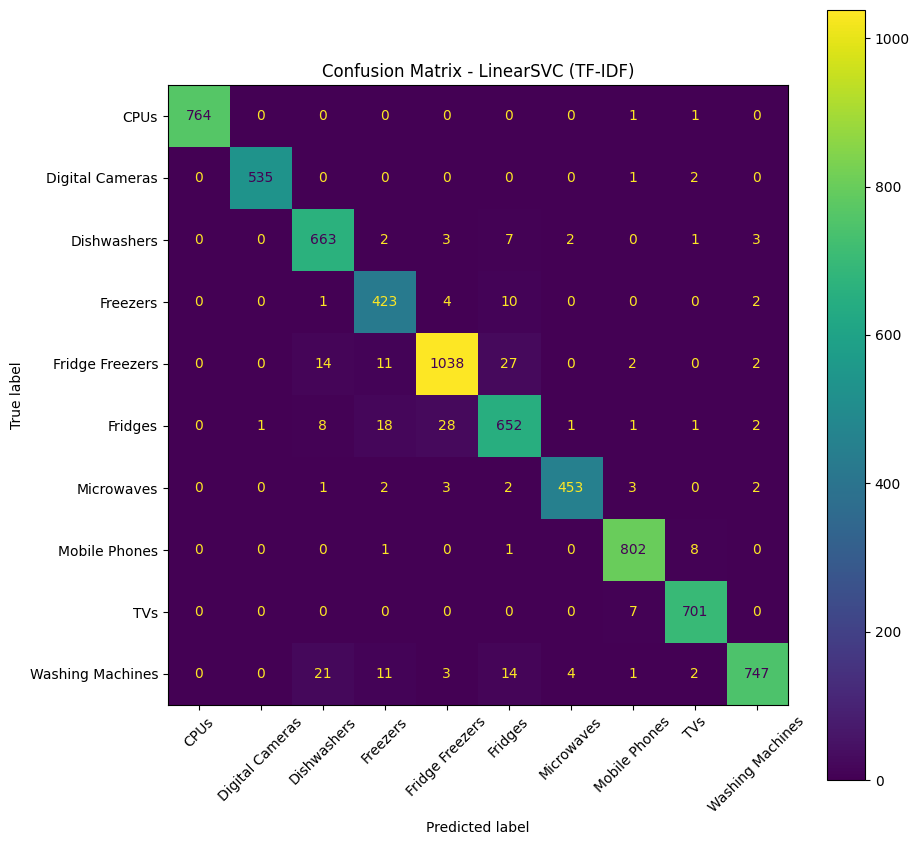

In [8]:
# Confusion matrix pentru LinearSVC
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(
    model_svc, X_test, y_test,
    xticks_rotation=45,
    ax=ax
)
plt.title("Confusion Matrix - LinearSVC (TF-IDF)")
plt.show()


In [9]:
# Comparam cele doua modele de baza intr-un tabel simplu
comparison_base = pd.DataFrame({
    "Model": ["TF-IDF + Logistic Regression", "TF-IDF + LinearSVC"],
    "Accuracy": [acc_lr, acc_svc]
}).sort_values("Accuracy", ascending=False)

comparison_base


,Model,Accuracy
1,TF-IDF + LinearSVC,0.965527
0,TF-IDF + Logistic Regression,0.957123


In [10]:
# Experiment 1: folosim CountVectorizer in loc de TF-IDF
# Scop: verificam daca TF-IDF chiar aduce un avantaj fata de numarari brute

model_count_svc = Pipeline([
    ("count", CountVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])

model_count_svc.fit(X_train, y_train)
pred_count_svc = model_count_svc.predict(X_test)
acc_count_svc = accuracy_score(y_test, pred_count_svc)

print("CountVectorizer + LinearSVC - Accuracy:", acc_count_svc)
print("\nClassification report:\n")
print(classification_report(y_test, pred_count_svc))


CountVectorizer + LinearSVC - Accuracy: 0.9601139601139601

Classification report:

                  precision    recall  f1-score   support

            CPUs       1.00      1.00      1.00       766
 Digital Cameras       1.00      0.99      0.99       538
     Dishwashers       0.92      0.98      0.95       681
        Freezers       0.90      0.95      0.92       440
 Fridge Freezers       0.96      0.94      0.95      1094
         Fridges       0.91      0.90      0.90       712
      Microwaves       0.99      0.97      0.98       466
   Mobile Phones       0.99      0.99      0.99       812
             TVs       0.96      1.00      0.98       708
Washing Machines       0.97      0.92      0.95       803

        accuracy                           0.96      7020
       macro avg       0.96      0.96      0.96      7020
    weighted avg       0.96      0.96      0.96      7020



In [11]:
# Experiment 2: adaugam cateva caracteristici numerice simple derivate din titlu.
# Scop: vedem daca ajuta in clasele apropiate (ex: fridges vs freezers)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

def add_text_features(df_in):
    df_out = df_in.copy()

    df_out["title_length"] = df_out["Product Title"].str.len()
    df_out["word_count"] = df_out["Product Title"].str.split().str.len()
    df_out["has_numbers"] = df_out["Product Title"].str.contains(r"\d").astype(int)

    brands = ["bosch", "samsung", "iphone", "apple", "lg", "sony", "smeg", "olympus", "kenwood"]
    pattern = "|".join(brands)
    df_out["has_brand"] = df_out["Product Title"].str.contains(pattern).astype(int)

    return df_out

df_fe = add_text_features(df)

X_fe = df_fe[["Product Title", "title_length", "word_count", "has_numbers", "has_brand"]]
y_fe = df_fe["Category Label"]

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=42, stratify=y_fe
)

text_col = "Product Title"
num_cols = ["title_length", "word_count", "has_numbers", "has_brand"]

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.95), text_col),
        ("num", StandardScaler(), num_cols)
    ]
)

model_tfidf_fe_svc = Pipeline([
    ("features", preprocessor),
    ("clf", LinearSVC(class_weight="balanced", random_state=42))
])

model_tfidf_fe_svc.fit(X_train_fe, y_train_fe)
pred_tfidf_fe_svc = model_tfidf_fe_svc.predict(X_test_fe)

acc_tfidf_fe_svc = accuracy_score(y_test_fe, pred_tfidf_fe_svc)

print("TF-IDF + Feature Engineering + LinearSVC - Accuracy:", acc_tfidf_fe_svc)
print("\nClassification report:\n")
print(classification_report(y_test_fe, pred_tfidf_fe_svc))


TF-IDF + Feature Engineering + LinearSVC - Accuracy: 0.9672364672364673

Classification report:

                  precision    recall  f1-score   support

            CPUs       1.00      1.00      1.00       766
 Digital Cameras       1.00      0.99      1.00       538
     Dishwashers       0.93      0.98      0.95       681
        Freezers       0.91      0.96      0.93       440
 Fridge Freezers       0.97      0.95      0.96      1094
         Fridges       0.92      0.91      0.92       712
      Microwaves       0.98      0.97      0.98       466
   Mobile Phones       0.99      0.99      0.99       812
             TVs       0.98      1.00      0.99       708
Washing Machines       0.98      0.94      0.96       803

        accuracy                           0.97      7020
       macro avg       0.97      0.97      0.97      7020
    weighted avg       0.97      0.97      0.97      7020



In [12]:
# Facem un tabel final cu toate variantele testate
comparison_all = pd.DataFrame({
    "Model": [
        "TF-IDF + Logistic Regression",
        "TF-IDF + LinearSVC",
        "CountVectorizer + LinearSVC (experiment)",
        "TF-IDF + FE + LinearSVC (experiment)"
    ],
    "Accuracy": [
        acc_lr,
        acc_svc,
        acc_count_svc,
        acc_tfidf_fe_svc
    ]
}).sort_values("Accuracy", ascending=False)

comparison_all


,Model,Accuracy
3,TF-IDF + FE + LinearSVC (experiment),0.967236
1,TF-IDF + LinearSVC,0.965527
2,CountVectorizer + LinearSVC (experiment),0.960114
0,TF-IDF + Logistic Regression,0.957123


In [13]:
# Concluzie:
# - Am comparat doua modele de baza cu TF-IDF (LogReg vs LinearSVC).
# - Am rulat doua experimente:
#   1) CountVectorizer in loc de TF-IDF
#   2) Feature engineering simplu combinat cu TF-IDF
# - Pastram un model final clar si usor de folosit.

import joblib
import os

# Alegem modelul final dintre cele doua modele de baza
if acc_svc >= acc_lr:
    final_model = model_svc
    final_model_name = "TF-IDF + LinearSVC"
else:
    final_model = model_lr
    final_model_name = "TF-IDF + Logistic Regression"

print("Model final ales:", final_model_name)

# Salvam modelul final
os.makedirs("/content/models", exist_ok=True)

FINAL_MODEL_PATH = "/content/models/product_category_model.pkl"
joblib.dump(final_model, FINAL_MODEL_PATH)

FINAL_MODEL_PATH


Model final ales: TF-IDF + LinearSVC


'/content/models/product_category_model.pkl'

In [14]:
# Testam modelul final cu exemplele din cerinta
tests = [
    "iphone 7 32gb gold,4,3,Apple iPhone 7 32GB",
    "olympus e m10 mark iii geh use silber",
    "kenwood k20mss15 solo",
    "bosch wap28390gb 8kg 1400 spin",
    "bosch serie 4 kgv39vl31g",
    "smeg sbs8004po"
]

for t in tests:
    print(t, "=>", final_model.predict([t.lower().strip()])[0])


iphone 7 32gb gold,4,3,Apple iPhone 7 32GB => Mobile Phones
olympus e m10 mark iii geh use silber => Digital Cameras
kenwood k20mss15 solo => Microwaves
bosch wap28390gb 8kg 1400 spin => Washing Machines
bosch serie 4 kgv39vl31g => Dishwashers
smeg sbs8004po => Fridges
